In [1]:
from copy import deepcopy
import pandas as pd
import numpy as np
import json, gzip, os, re, gensim, sys
import datetime as dt
from collections import Counter
from scipy.stats import spearmanr, pearsonr
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import r2_score, make_scorer, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.base import clone
from sklearn.dummy import DummyRegressor
import clustfunc1
import importlib
from matplotlib import pyplot as plt
from itertools import chain, combinations
from sklearn.feature_selection import RFECV, SelectFpr, f_regression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from itertools import chain, combinations, product
from scipy.spatial.distance import cosine

In [2]:
parameters = {'DecisionTreeRegressor': [{'criterion': ['mae'], 'max_depth': [2, 3], 'min_samples_leaf': [2],
                                         'max_leaf_nodes': [3], 'splitter': ['best'], 'min_samples_split': [2],
                                         'max_features': ['auto'], 'random_state': [42]}],
              'RandomForestRegressor': [{'n_estimators': [2, 5, 10, 20], 'max_depth': [2, 3],
                                        'min_samples_split': [2], 'min_samples_leaf': [1], 'max_features': ['auto'],
                                         'random_state': [42]}],
              'AdaBoostRegressor': [{'loss': ['linear', 'square', 'exponential'], 'n_estimators': [10, 100], 'random_state': [42]}],
              'Ridge': [{'alpha': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 'normalize': [False, True]}],
              'Lasso': [{'alpha': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 'normalize': [False, True],
                         'selection': ['cyclic', 'random'], 'random_state': [42], 'max_iter': [500, 1000, 2000]}],
              'ElasticNet': [{'alpha': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 'normalize': [False, True],
                         'selection': ['cyclic', 'random'], 'random_state': [42], 'max_iter': [500, 1000],
                              'l1_ratio': [0.25, 0.5, 0.75]}],
              'LinearRegression': [{'normalize': [False, True]}]
             }



models = {'DecisionTreeRegressor': DecisionTreeRegressor(),
          'RandomForestRegressor': RandomForestRegressor(),
          'Ridge': Ridge(),
          'AdaBoostRegressor': AdaBoostRegressor(),
          'LinearRegression': LinearRegression(),
          'Lasso': Lasso(),
          'ElasticNet': ElasticNet()}

In [3]:
def set_params(func, parameters):
    for parameter, value in parameters.items():
        if hasattr(func, parameter):
            setattr(func, parameter, value)
    return func

In [4]:
gfoo = '../gold_split/'
g1 = pd.read_csv(gfoo+'traincorr1.csv', index_col=[0, 1, 2])
g2 = pd.read_csv(gfoo+'testcorr1.csv', index_col=[0,1, 2])
g = pd.concat([g1, g2])

In [5]:
wbs = ['Diener', 'WHO']
feats = ['clusters', 'words', 'Meta', 'AppCats', 'RuLIWC']
indeces = [[0,1], [0,1], [0,1,2], [0,1,2], [0,1,2]]

appdata1 = pd.read_csv('AppCatsBy3HoursNorm-1.csv', index_col=0)
print(appdata1.shape)

#print(appdata1)

data = {'clusters':{}}

whodata = pd.read_csv(gfoo + 'h-clustersVERYRARE_WHO.csv', index_col = [0,1])
dienerdata = pd.read_csv(gfoo + 'h-clustersRARE_Diener.csv', index_col = [0,1])
data['clusters']['WHO'] = g.join(whodata)[whodata.columns]
data['clusters']['Diener'] = g.join(dienerdata)[dienerdata.columns]

data['AppCats'] = g.join(appdata1, lsuffix = 'mail')[appdata1.columns]

wdf1 = pd.read_csv('RuLIWC-matrix-1year-traintest.csv', index_col = [0,1,2])
data['RuLIWC'] = g.join(wdf1, rsuffix = 'APP_')[wdf1.columns]

cols = g.dropna(axis=1).columns
cols = cols[2:]
cols = cols.drop(['MessNewest', 'MessOldest'])
data['Behavior'] = g[cols]

data['Words'] = pd.read_csv(gfoo+'words_selected.csv', index_col = [0,1,2])

rat = {'who': 25., 'diener': 30.}
metrs = ['MAE', 'Pearson', 'R-2']


(970, 235)


In [6]:
g.shape

(372, 99)

In [7]:
data['Behavior'].shape

(372, 46)

In [8]:
data['Behavior'].columns

Index(['gender_merged', 'age', 'NVkFriends', 'AllAlters', 'Mess_-1',
       'Alters_-1', 'MessChars_-1', 'Alters_-2', 'Alters_-3', 'Alters_-4',
       'Alters_-5', 'Alters_-6', 'Alters_-7', 'Alters_-8', 'Alters_-9',
       'Alters_-10', 'Alters_-11', 'Alters_-12', 'Subscriptions_gathered',
       'AppUsage1stWeek', 'AppUsage0-3', 'AppUsage3-6', 'AppUsage6-9',
       'AppUsage9-12', 'AppUsage12-15', 'AppUsage15-18', 'AppUsage18-21',
       'AppUsage21-24', 'AllAppTime1Week', 'RatioAppTime1Week',
       'AppUsage0-3Ratio', 'AppUsage3-6Ratio', 'AppUsage6-9Ratio',
       'AppUsage9-12Ratio', 'AppUsage12-15Ratio', 'AppUsage15-18Ratio',
       'AppUsage18-21Ratio', 'AppUsage21-24Ratio', 'Positive_month',
       'Negative_month', 'Positive_year', 'Negative_year', 'Positive_all',
       'Negative_all', 'growth-2to-1weighted', 'altersdiff'],
      dtype='object')

In [9]:
def eval_pars_nestedCV(X, y, wb, best_params, step=1, verbose=0, method='', fsname='', funcname='Ridge', bestfs = False,
                       fout=None, fout_mean=None):
    grids = parameters[funcname]
    
    wb = wb.lower()
    sortedarg = np.asarray(y.argsort())
    cv = []
    X = np.asarray(X)
    y = np.asarray(y)
    for i in range(5):
        for j in range(2):
            if j:
                di = i*2 
                ti = i*2+1
            else:
                di = i*2+1 
                ti = i*2
            dev = sortedarg[di::10]
            test = sortedarg[ti::10]
            train = np.setdiff1d(sortedarg, np.concatenate((dev, test)))
            cv.append([train, dev, test])
    
    maes, prs, r2s = [], [], []
    bestmae = 1000
    devmaes = []
    preds, trues = [], []
    bestfeats, ests = [], []
    for i, [train, dev, test] in enumerate(cv):
        #print(i, 'CV fold..')
        #print(len(train), len(dev), len(test))
        est = set_params(deepcopy(models[funcname]), best_params)
        if method == 'RFECV':
            fs = RFECV(est, cv = [[train, dev]], scoring=make_scorer(mae, greater_is_better = False), step = step, 
                       verbose = 0)
        elif method == 'Seq':
            fs = SequentialFeatureSelector1(est, cv = [[train, dev]], scoring=make_scorer(mae, greater_is_better = False), step = step)
        #print(X.shape, y.shape)
        if verbose:
            print('Fold ', i)
        fs.fit(X, y)
        if verbose:
            print(fs.n_features_, flush = True)
        if bestfs:
            bestfeats.append(fs.support_)
            ests.append(fs.estimator_)
        resmae = fs.grid_scores_.max()/-rat[wb]
        if verbose:
                        print(resmae, flush = True)
        devmaes.append(resmae)
        est = set_params(deepcopy(models[funcname]), best_params)
        #print(X[train].shape, np.concatenate((X[train], X[dev])).shape)
        #print(bestfs.transform(X[train]).shape, bestfs.transform(np.concatenate((X[train], X[dev]))).shape)
        est.fit(fs.transform(np.concatenate((X[train], X[dev]))), np.concatenate((y[train], y[dev])))
        testpred = est.predict(fs.transform(X[test]))
        
        maes.append(mae(y[test], testpred)/rat[wb])
        pr = pearsonr(y[test], testpred)[0]
        if np.isnan(pr):
            pr = 0.0
        prs.append(pr)
        r2s.append(r2_score(y[test], testpred))
        preds+=list(testpred)
        trues += list(y[test])
        #if fout is not None:
        #    fout.write('{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\t{7}\t{8}\t{9}\n'.format(method, wb, fsname, funcname, i + 1,
        #                                                                      bestmae, cur_mae, cur_prs, cur_r2,
        #                                                                      json.dumps({k: v for k, v in best_params.items() if k != 'fs'})))
    print('Dev final: ', round(np.mean(devmaes), 4), flush = True)
    print('Test: ', [round(np.mean(x), 4) for x in [maes, prs, r2s]], flush = True)
    if fout_mean is not None:
        fout_mean.write('{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\t{7}\t{8}\n'.format(method, wb, fsname, funcname,
                                                                     round(np.mean(devmaes), 4),
                                                                     round(np.mean(maes), 4),
                                                                     round(np.mean(prs), 4),
                                                                     round(np.mean(r2s), 4),
                                                                     json.dumps({k: v for k, v in best_params.items() if k != 'fs'})))
        fout_mean.flush()
    return (trues, preds, bestfeats, ests)

In [ ]:
Diener: '12_cos_50.0_1.0.txt' (86 кластеров), 
Diener RARE: '12_cos_100.0_1.0RARE.txt'
Diener VERYRARE: ./h-clusters0104/12_cos_50.0_1.0VERYRARE.txt
Diener VERYRARE CORR: ./h-clusters0104/14_cos_100.0_1.0VERYRARE.txt
Diener ULTIM VERYRARE: ./h-clusters0104/14_cos_500.0_1.0VERYRARE.txt

In [ ]:
WHO: '14_cos_1.0_0.0.txt' (96 кластеров), 
WHO RARE: '12_cos_50.0_1.0RARE.txt' (86 кластеров)
WHO VERYRARE: ./h-clusters0104/14_cos_500.0_1.0VERYRARE.txt

In [10]:
wb = 'WHO'
fs = ['clusters', 'AppCats', 'RuLIWC', 'Behavior']
#fs = ['Behavior', 'Words']
traindata = pd.concat([data[x][wb] if x == 'clusters' else data[x] for x in fs], axis=1)
#func = 'AdaBoostRegressor'
#best_params = {"loss": "square", "n_estimators": 100, "random_state": 42}
func = 'Lasso'
best_params = {"alpha": 0.01, "max_iter": 500, "normalize": True, "selection": "random", "random_state": 42}


In [11]:
%%time
trues, preds, bestfeats, ests = eval_pars_nestedCV(traindata, g['DF_'+wb.lower()+'_score'], wb, best_params, step=1, verbose=1, method='RFECV', 
                   bestfs = True, fsname='', funcname=func, fout=None, fout_mean=None)

Fold  0
63
0.1328290300573986
Fold  1
46
0.15313186213689292
Fold  2
78
0.12234273377059132
Fold  3
64
0.14719991498163104
Fold  4
16
0.13864091571421416
Fold  5
52
0.14042030952969672
Fold  6
78
0.13320679478670222
Fold  7
35
0.14908152770777316
Fold  8
2
0.14274644413705725
Fold  9
10
0.136569579698097
Dev final:  0.1396
Test:  [0.1365, 0.4419, 0.1973]
CPU times: user 28.4 s, sys: 55.3 ms, total: 28.4 s
Wall time: 28.8 s


In [181]:
len(trues), len(preds)

(372, 372)

In [182]:
pearsonr(trues, preds)

(0.44823741050848065, 8.730401130631015e-20)

In [198]:
mae(trues, preds)/25.

0.13649732652104543

In [196]:
mae(trues, np.round(preds))/25.

0.13688172043010752

Text(0.5, 1.0, 'Best WHO prediction')

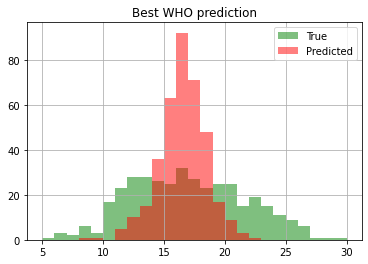

In [183]:
pd.Series(trues).hist(alpha=0.5, color = 'g', bins = range(5,31))
pd.Series(preds).hist(alpha=0.5, color = 'r', bins = range(5,31))
plt.legend(['True', 'Predicted'])
plt.title('Best WHO prediction')

Text(0, 0.5, 'Predicted')

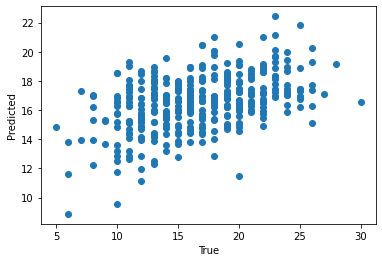

In [184]:
plt.scatter(trues, preds)
plt.xlabel('True')
plt.ylabel('Predicted')

In [15]:
e = ests[0]

In [16]:
t = e.estimators_[0]

AttributeError: 'Lasso' object has no attribute 'estimators_'

In [17]:
clus = pd.read_csv('./h-clusters0104/14_cos_500.0_1.0VERYRARE.txt', index_col = 0)
clus

,WHO_PearsonR,WHO_P,Diener_PearsonR,Diener_P,ex
2247,-0.168047,0.000198,-0.108071,0.017742,"наорать_VERB, психануть_VERB, нагрубить_VERB, ..."
2,-0.166121,0.000235,-0.015263,0.738454,"аааа_NOUN, ааааа_NOUN, аааааа_NOUN, ыыы_NOUN, ..."
1343,-0.159801,0.000405,-0.110026,0.015774,"заплакать_VERB, разреветься_VERB, расплакаться..."
4258,-0.155405,0.000586,-0.116538,0.010529,"стремный_ADJ, стрёмный_ADJ, гиблый_ADJ, дибиль..."
4591,-0.149719,0.000930,-0.095382,0.036509,"умереть_VERB, умирать_VERB, казнить_VERB, поги..."
...,...,...,...,...,...
682,-0.000439,0.992294,0.013257,0.771819,"вылетать_VERB, вылететь_VERB, влетать_VERB, вы..."
1351,0.000227,0.996024,-0.159236,0.000456,"запретить_VERB, запрещать_VERB, ведомо_NOUN, з..."
47,-0.000221,0.996124,0.000673,0.988255,"акварель_NOUN, изображение_NOUN, портрет_NOUN,..."
3403,0.000216,0.996206,-0.010174,0.823883,"присниться_VERB, сниться_VERB, бредить_VERB, в..."


In [18]:
clus.loc[2247, 'ex']

'наорать_VERB, психануть_VERB, нагрубить_VERB, надавать_VERB, накипеть_VERB, накричать_VERB, отчитать_VERB, подзатыльник_NOUN, прикопаться_VERB, проораться_VERB, разныться_VERB, разораться_VERB, распсиховаться_VERB'

In [19]:
a = '45'

In [20]:
a.isnumeric()

True

In [21]:
fd1 = {}
for i,bf in enumerate(bestfeats):
    cols = traindata.columns[bf]
    #print(cols)
    for j,col in enumerate(cols):
        fd1[col] = fd1.get(col, {})
        fd1[col]['imps'] = fd1[col].get('imps', [])
        fd1[col]['imps'].append(ests[i].coef_[j])
for col in fd1.keys():
    fd1[col]['count'] = len(fd1[col]['imps'])
    fd1[col]['mean_imp'] = np.mean(fd1[col]['imps'])
    if col.isnumeric():
        fd1[col]['contents'] = clus.loc[int(col), 'ex']
    else:
        fd1[col]['contents'] = ''
fdf1 = pd.DataFrame().from_dict(fd1, orient = 'index')
fdf1['abs_mean_imp'] = fdf1.mean_imp.abs()
fdf1.sort_values(by = ['count', 'abs_mean_imp'], ascending=False).drop(['abs_mean_imp', 'imps'], axis=1).to_csv('WHO_VERYRARE_best_feats.csv')

In [22]:
fdf1

,imps,count,mean_imp,contents,abs_mean_imp
97,"[1484.693602190301, 1558.4282438514238, 1348.5...",9,1535.711994,"анатомия_NOUN, биология_NOUN, география_NOUN, ...",1535.711994
238,"[-368.19104987345065, -395.9022073438478, -533...",7,-398.059049,"бить_VERB, грызть_VERB, давить_VERB, долбить_V...",398.059049
262,"[-4804.528958401443, -4449.3718523740035, -484...",10,-4857.353960,"блядский_ADJ, гребанный_ADJ, гребаный_ADJ, ебу...",4857.353960
603,"[-498.8033118332397, -572.6412688690319, -436....",7,-506.672320,"временами_ADV, всегда_ADV, ежедневно_ADV, зача...",506.672320
740,"[-592.3312179000808, -747.6521824219689, -831....",8,-637.608780,"выяснить_VERB, выяснять_VERB, разобраться_VERB...",637.608780
...,...,...,...,...,...
HEALTH+MEDICAL_3,"[0.0001084559047664495, 0.0001084559047664495]",2,0.000108,,0.000108
PHOTOGRAPHY_0,"[0.0005100416121752582, 0.0005100416121752582]",2,0.000510,,0.000510
PHOTOGRAPHY_5,"[0.00033393183521931134, 0.00033393183521931134]",2,0.000334,,0.000334
Alters_-7,"[0.02169705189281048, 0.02169705189281048]",2,0.021697,,0.021697


In [23]:
dwb = 'Diener'
dfs = ['clusters', 'AppCats', 'Behavior', 'Words']
dtraindata = pd.concat([data[x][dwb] if x == 'clusters' else data[x] for x in dfs], axis=1)
dfunc = 'Lasso'
dbest_params = {"alpha": 0.01, "max_iter": 500, "normalize": True, "selection": "random", "random_state": 42}


In [24]:
%%time
dtrues, dpreds, dbestfeats, dests = eval_pars_nestedCV(dtraindata, g['DF_'+dwb.lower()+'_score'], dwb, dbest_params, step=1, 
                                                       verbose=1, 
                                    bestfs = True, method='RFECV', fsname='', funcname=dfunc, fout=None, fout_mean=None)

Fold  0
72
0.1808050228533396
Fold  1
21
0.16527764453744015
Fold  2
6
0.1798236538520251
Fold  3
7
0.16792344399264852
Fold  4
71
0.17033487218137555
Fold  5
80
0.1675526432525113
Fold  6
25
0.17885164707042644
Fold  7
13
0.18851628388584238
Fold  8
21
0.17175018651143295
Fold  9
119
0.17421457194451528
Dev final:  0.1745
Test:  [0.1626, 0.4338, 0.18]
CPU times: user 1min 46s, sys: 146 ms, total: 1min 46s
Wall time: 1min 47s


In [185]:
pearsonr(dtrues, dpreds)

(0.42651983561015305, 7.076288614028265e-18)

In [195]:
mae(dtrues, dpreds)/30., r2_score(dtrues, dpreds)

(0.1625747554820557, 0.18057555013086812)

In [194]:
mae(dtrues, np.round(dpreds))/30., r2_score(dtrues, np.round(dpreds))

(0.16272401433691758, 0.1786505861848542)

In [192]:
dpreds

[13.806537146370546,
 18.640453760273658,
 15.680520409520126,
 13.915095477758138,
 19.4683989053286,
 18.272425188672024,
 22.252756952236044,
 8.901559858365161,
 15.112482380820545,
 19.04823805078799,
 17.649527815093336,
 14.862459544423729,
 17.68962875695584,
 16.00134103986572,
 19.83758253304282,
 18.848126792088895,
 17.39363644054581,
 19.52698594133226,
 17.876162715644643,
 17.304520665575456,
 20.445524309167997,
 18.2940025540132,
 20.817934417722583,
 17.964649936169224,
 20.365406525664614,
 21.751089130379004,
 22.686279298794236,
 18.558191270508633,
 21.265695212239308,
 15.586736161108492,
 17.96268824273713,
 21.683768808183697,
 17.897336561109984,
 20.438116595838995,
 19.245686064429172,
 19.320912140663953,
 20.302637094291512,
 21.00343643170287,
 19.975119229971515,
 15.30295295965551,
 17.987546043796392,
 14.602062911852766,
 11.216582303086625,
 18.428294754578232,
 16.63964693463974,
 13.050474851458748,
 19.975119229971515,
 18.550477879011225,
 16.191

Text(0, 0.5, 'Predicted')

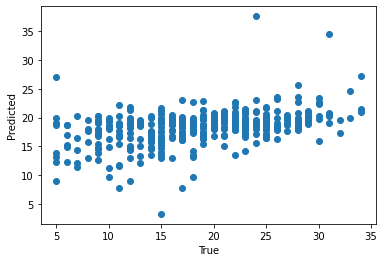

In [186]:
plt.scatter(dtrues, dpreds)
plt.xlabel('True')
plt.ylabel('Predicted')

In [26]:
fd = {}
for i,dbf in enumerate(dbestfeats):
    cols = dtraindata.columns[dbf]
    #print(cols)
    for j,col in enumerate(cols):
        fd[col] = fd.get(col, {})
        fd[col]['imps'] = fd[col].get('imps', [])
        fd[col]['imps'].append(dests[i].coef_[j])
for col in cols:
    fd[col]['count'] = len(fd[col]['imps'])
    fd[col]['mean_imp'] = np.mean(fd[col]['imps'])
fdf = pd.DataFrame().from_dict(fd, orient = 'index')
fdf['abs_mean_imp'] = fdf.mean_imp.abs()
fdf.sort_values(by = ['count', 'abs_mean_imp'], ascending=False).drop(['abs_mean_imp', 'imps'], axis=1).to_csv('Diener_best_feats.csv')

In [27]:
fdf

,imps,count,mean_imp,abs_mean_imp
529,"[-3634.0079788131534, -3762.7537146563036, -34...",4,-3417.772070,3417.772070
1288,"[3981.03080640992, 4027.7015356196944, 3876.87...",4,3487.888276,3487.888276
1366,"[2009.1714157966483, 2262.9494731379473, 1650....",4,1867.154228,1867.154228
1525,"[-3367.6786866606312, -3427.278871835201, -247...",4,-2978.340596,2978.340596
1612,"[-3413.7970081056337, -2514.5151922254704, -33...",4,-4083.104355,4083.104355
...,...,...,...,...
вскрыться_VERB,[1685.986937429397],1,1685.986937,1685.986937
инглихой_COMP,[5058.283120648706],1,5058.283121,5058.283121
ебу_UNKN,[803.9023825909638],1,803.902383,803.902383
лень_NOUN,[-488.9072945948903],1,-488.907295,488.907295


In [28]:
dests[0]

Lasso(alpha=0.01, max_iter=500, normalize=True, random_state=42,
      selection='random')

In [29]:
est.coef_.shape

NameError: name 'est' is not defined

In [86]:
bfs = []
for bf in dbestfeats:
    bfs += list(dtraindata.columns[bf])

In [88]:
c = Counter(bfs)

In [89]:
c.most_common()

[('милый_COMP', 10),
 ('ооохнуть_VERB', 10),
 ('спойлерить_VERB', 10),
 ('вифя_NOUN', 10),
 ('отл_UNKN', 10),
 ('интим_NOUN', 10),
 ('тратиться_VERB', 9),
 ('мразь_NOUN', 8),
 ('стебать_VERB', 8),
 ('пояснение_NOUN', 8),
 ('пиздуть_VERB', 8),
 ('объёмный_ADJ', 8),
 ('орг_NOUN', 8),
 ('пиздёжа_NOUN', 7),
 ('фандом_NOUN', 7),
 ('шов_NOUN', 7),
 ('предать_VERB', 7),
 ('ложь_NOUN', 7),
 ('дельфин_NOUN', 7),
 ('чонгук_NOUN', 7),
 ('помеха_NOUN', 7),
 ('блч_UNKN', 5),
 ('пожениться_VERB', 5),
 ('научный_ADJ', 5),
 ('еби_UNKN', 5),
 ('529', 4),
 ('1288', 4),
 ('1366', 4),
 ('1525', 4),
 ('1612', 4),
 ('1770', 4),
 ('хит_NOUN', 4),
 ('лосиный_ADJ', 4),
 ('неудобный_ADJ', 4),
 ('ебал_NOUN', 4),
 ('хл_UNKN', 4),
 ('подробный_ADJ', 4),
 ('критерий_NOUN', 4),
 ('будто_CONJ', 4),
 ('замечание_NOUN', 4),
 ('маркетинг_NOUN', 4),
 ('воскресение_NOUN', 4),
 ('сук_NOUN', 4),
 ('коль_CONJ', 4),
 ('мэн_NOUN', 4),
 ('пират_NOUN', 4),
 ('наверна_NOUN', 4),
 ('писаться_VERB', 4),
 ('звёздочка_NOUN', 4),
 ('д

In [84]:
dtraindata.columns[dbestfeats[1]]

Index(['пиздёжа_NOUN', 'милый_COMP', 'фандом_NOUN', 'мразь_NOUN',
       'ооохнуть_VERB', 'спойлерить_VERB', 'вифя_NOUN', 'стебать_VERB',
       'пояснение_NOUN', 'шов_NOUN', 'отл_UNKN', 'пиздуть_VERB',
       'тратиться_VERB', 'объёмный_ADJ', 'предать_VERB', 'ложь_NOUN',
       'дельфин_NOUN', 'орг_NOUN', 'чонгук_NOUN', 'интим_NOUN', 'помеха_NOUN'],
      dtype='object')

Text(0.5, 1.0, 'Best Diener prediction')

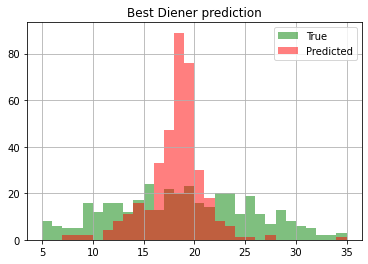

In [71]:
pd.Series(dtrues).hist(alpha=0.5, color = 'g', bins = range(5,36))
pd.Series(dpreds).hist(alpha=0.5, color = 'r', bins = range(5,36))
plt.legend(['True', 'Predicted'])
plt.title('Best Diener prediction')

In [168]:
fns = [fn for fn in os.listdir('./') if fn.endswith('.ipynb')]
for fn in fns:
    f = open('./' + fn, 'r')
    for line in f:
        if 'altersdiff' in line:
            print(fn, line)
    f.close()

appinfo_fork.ipynb        "      <th>altersdiff</th>\n",

appinfo_fork.ipynb        "                                      altersdiff  \n",

final regr3.ipynb        "      <th>altersdiff</th>\n",

final regr3.ipynb        "                                                                            altersdiff  \n",

final regr3.ipynb        "      <th>altersdiff</th>\n",

final regr3.ipynb        "                                                                            altersdiff  \n",

final regr3.ipynb       "       'Positive_all', 'Negative_all', 'growth-2to-1weighted', 'altersdiff'],\n",

final regr3.ipynb        "      <th>altersdiff</th>\n",

final regr3.ipynb        "                                                                            altersdiff  \\\n",

final regr3.ipynb       "Negative_month, 😘_UNKN, AppUsage9-12Ratio, Alters_-7, 111, APP_PHOTOGRAPHY_0_Ratio, 164, по_PREP, тот_ADJ, AllAlters, 116, 142, 212, 105, 140, 278, 241, 84, gender_merged, See_RuLIWC, 270, 203,

In [169]:
fns = [fn for fn in os.listdir('./') if fn.endswith('.ipynb')]
for fn in fns:
    f = open('./' + fn, 'r')
    for line in f:
        if '.to_csv(gfoo' in line:
            print(fn, line)
    f.close()

cluster_heldout.ipynb     "wdf1.to_csv(gfoo + 'train+heldout-words1year.csv')"

cluster_final_eval.ipynb     "g1.to_csv(gfoo + 'traincorr.csv')\n",

cluster_final_eval.ipynb     "g2.to_csv(gfoo + 'testcorr.csv')\n",

clusteval_overview-Copy1.ipynb     "pd.concat(resdata['diener']).to_csv(gfoo+'Cosclusters_Diener.csv')"

clusteval_overview.ipynb     "pd.concat(resdata['who']).to_csv(gfoo+'clustersGen_WHO.csv')"

clusteval_overview.ipynb     "pd.concat(resdata1['diener']).to_csv(gfoo+'clustersGen_aswho_Diener.csv')"

final regr4.ipynb     "data['Words'].to_csv(gfoo+'words_selected.csv')"

lemmas_eval.ipynb     "pd.concat([dftrain[cols1], dftest[cols1]]).to_csv(gfoo+'words1_WHO.csv')\n",

lemmas_eval.ipynb     "dfbig[cols1].to_csv(gfoo+'words1big_WHO.csv')"

lemmas_eval.ipynb     "pd.concat([dftrain[cols2], dftest[cols2]]).to_csv(gfoo+'words1_Diener.csv')\n",

lemmas_eval.ipynb     "dfbig[cols2].to_csv(gfoo+'words1big_Diener.csv')"

cluster_heldout_3003.ipynb     "freqsdf.to_csv(gfoo + 'h